In [57]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
import sklearn.model_selection as model_selection
import contextily as cx
import geopandas as gpd
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats

gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"
#pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [129]:
all_data = pd.read_csv('resources/data_position_poi.csv')

RangeIndex(start=0, stop=33222, step=1)

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price)'}>],
       [<AxesSubplot:title={'center':'log(price + 1)'}>,
        <AxesSubplot:title={'center':'boxcox(price)'}>]], dtype=object)

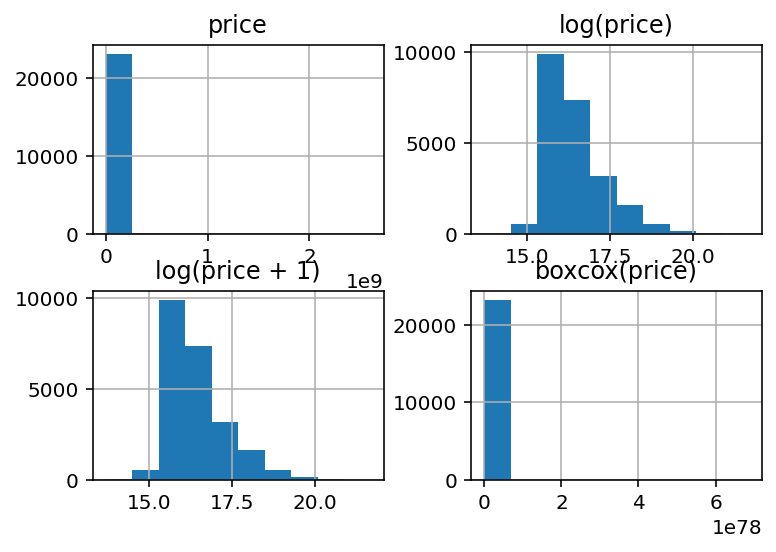

In [59]:
boxcox_price, price_lambda = stats.boxcox(all_data.price)
prices = pd.DataFrame({"price": all_data["price"], "log(price)": np.log(all_data['price']), "log(price + 1)":np.log1p(all_data['price']), "boxcox(price)": boxcox_price})
prices.hist()

0.05066524168787019

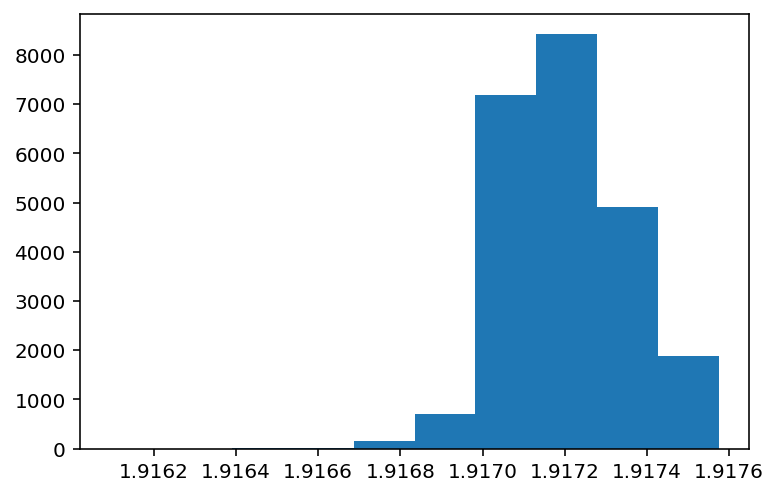

In [68]:
boxcox_price, price_lambda = stats.boxcox(data.price)
plt.hist(boxcox_price)
skew(boxcox_price)

In [95]:
NUMERIC_FEATURES = ["latitude", "longitude", "constructed", "area_total",
            "rooms", "balconies", "loggias", "metro_distance", "park_distance",
            "square_distance", "stories","floor", "ceiling", "bathrooms_shared", "bathrooms_private", "phones"]
CATEGORICAL_FEATURES = ["seller", "district", "material", "condition", "heating", "new", 
                "layout", "windows_court", "windows_street", "parking", "garbage_chute", "elevator_passenger", "elevator_without", "elevator_service"]
all_data[CATEGORICAL_FEATURES] = all_data[CATEGORICAL_FEATURES].astype('category')

In [96]:
#log transform the target:
all_data['price'] = np.log1p(all_data['price'])

#log transform skewed numeric features:

skewed_feats = all_data[NUMERIC_FEATURES].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print(skewed_feats)

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Index(['area_total', 'rooms', 'balconies', 'loggias', 'metro_distance',
       'park_distance', 'square_distance', 'stories', 'floor', 'ceiling',
       'bathrooms_shared', 'bathrooms_private'],
      dtype='object')


In [97]:
all_data = pd.get_dummies(all_data, columns  = CATEGORICAL_FEATURES)

In [98]:
all_data = all_data.fillna(all_data.mean())

In [108]:
data = all_data.loc[all_data['split'] == 'train', :]
data = data.drop(columns=['split'])

data_test = all_data.loc[all_data['split'] == 'test', :]
data_test = data_test.drop(columns=['split', 'price'])

In [109]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
X_train = data.drop(columns=['price', 'address', 'street'])
y = data.price

def rmlse_cv(model):
    rmlse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_log_error", cv = 5))
    return(rmlse)

In [110]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmlse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmsle')

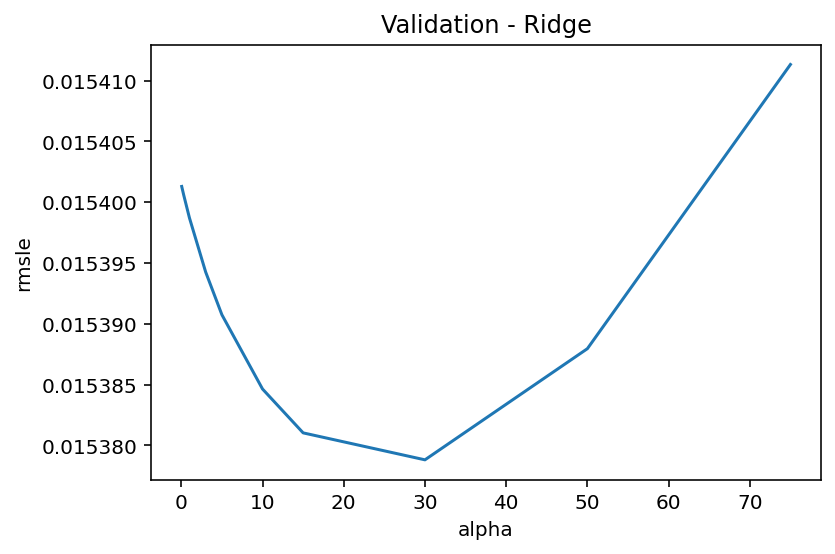

In [113]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmsle")

In [114]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [118]:
rmlse_cv(model_lasso).mean()

0.015385279324595718

In [119]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [120]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 56 variables and eliminated the other 16 variables


In [121]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

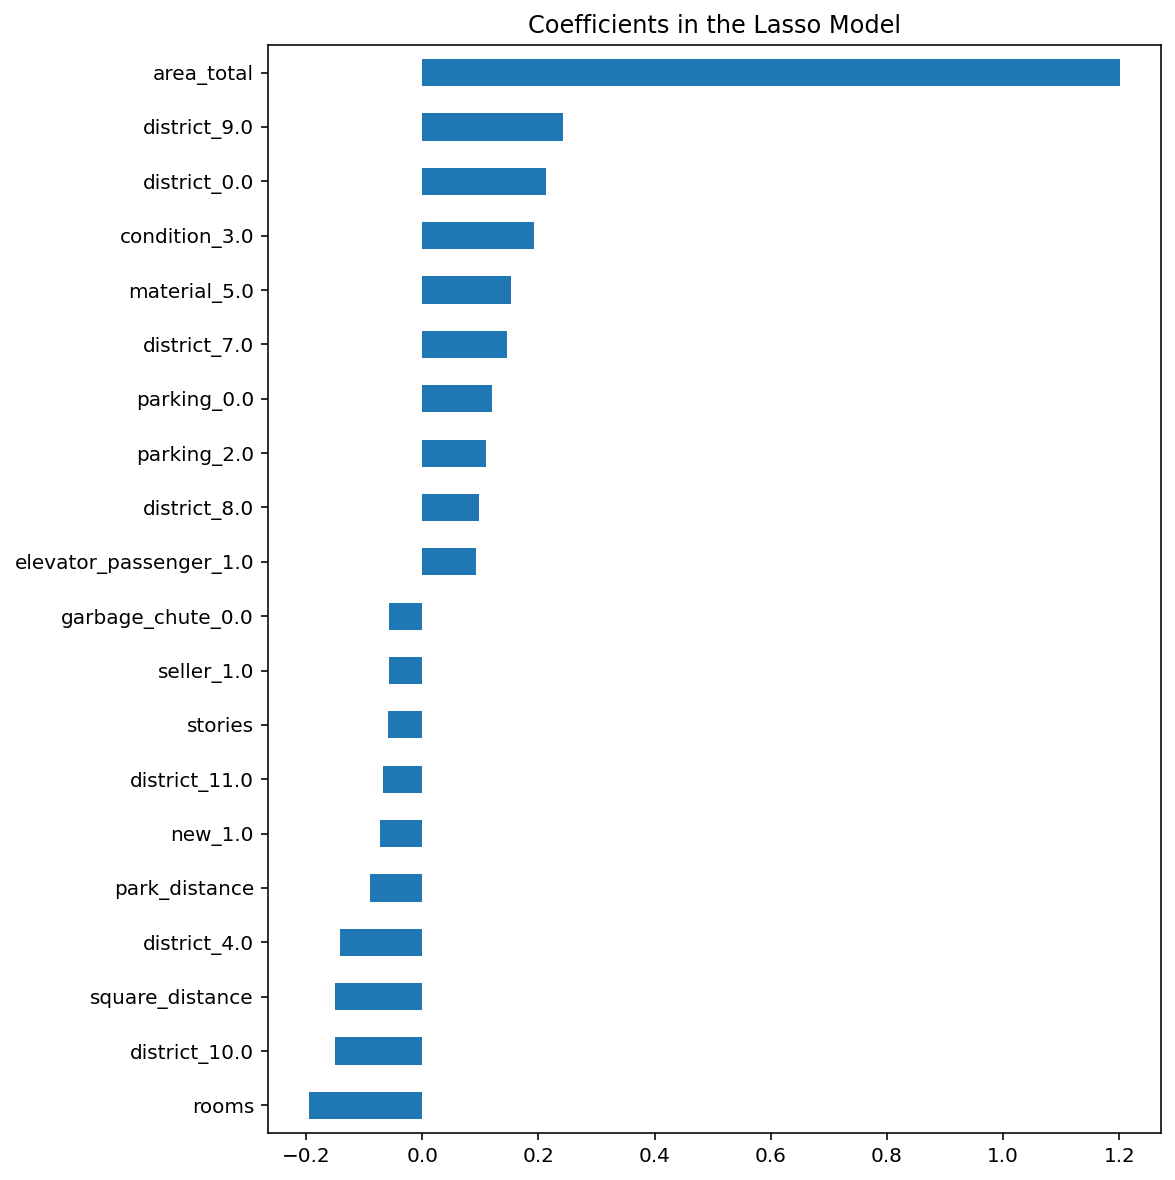

In [123]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [131]:
X_test = data_test.drop(columns=['address', 'street'])
preds = np.exp(model_lasso.predict(X_test)) - 1

submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = preds
submission.to_csv('submissions/lasso_sub.csv', index=False)

In [12]:
def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [13]:
data['latlong'] = data.latitude * data.longitude
data_test['latlong'] = data_test.latitude * data_test.longitude

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
data['area_per_room'] = np.log(data['area_total']/data['rooms'])
data_test['area_per_room'] = np.log(data_test['area_total']/data_test['rooms'])

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
# Scaling
df_scaled = data.copy()
district = pd.get_dummies(df_scaled.district)
df_scaled[['area_total', 'latlong', 'area_per_room', 'floor', 'park_distance', 'metro_distance', 'square_distance', 'rooms']] = df_scaled[['area_total', 'latlong', 'area_per_room', 'floor', 'park_distance', 'metro_distance', 'square_distance', 'rooms']].apply(np.log1p)

In [43]:
df

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23280,0,0,0,0,0,0,0,0,0,0,1,0
23281,0,0,0,0,0,0,0,0,0,0,1,0
23282,0,0,0,0,0,0,0,1,0,0,0,0
23283,0,0,0,0,0,0,1,0,0,0,0,0


In [31]:
df_scaled_test = data_test.copy()
df_scaled_test[['area_total', 'latlong', 'area_per_room', 'floor', 'park_distance', 'metro_distance', 'square_distance', 'rooms']] = df_scaled_test[['area_total', 'latlong', 'area_per_room', 'floor', 'park_distance', 'metro_distance', 'square_distance', 'rooms']].apply(np.log1p)

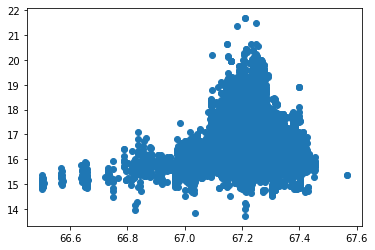

In [48]:
plt.scatter(np.sqrt(df_scaled.longitude**2 + df_scaled.latitude**2), np.log(df_scaled.price))

In [16]:
# Re-encoding district by mean value
agg = data.groupby('district').aggregate('mean')['price'].sort_values(ascending = True)
encoding = dict()
for i in range(12):
    encoding[agg.index[i]] = i
encoding

data['district_enc'] = np.empty(data.shape[0])
for i in range(data.shape[0]):
    if(not pd.isna(data['district'][i])):
        data['district_enc'][i] = encoding[data['district'][i]]

data_test['district_enc'] = np.empty(data_test.shape[0])
for i in range(data_test.shape[0]):
    if(not pd.isna(data_test['district'][i])):
        data_test['district_enc'][i] = encoding[data_test['district'][i]]

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

KeyError: 0

In [138]:
from sklearn.model_selection import KFold

def objective_lasso(trial,X,y, area):
    
    param = {
        "alpha": trial.suggest_loguniform(name = "alpha", low = 1e-5, high= 3)
    }
   
    model = Lasso(**param)

    cv = KFold(n_splits= 5, shuffle=True, random_state= 42)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        
        preds = np.exp(model.predict(X_test)) - 1
        y_true = np.exp(y_test) - 1
        cv_scores[idx] = rmlse(y_true, preds)
    
    return np.mean(cv_scores)

In [139]:
from sklearn.linear_model import Lasso
import optuna

area = data.area_total
#features = ['area_total', 'square_distance', 'area_per_room', 'rooms']
#X, y = df_scaled[features], np.log(data.price)

lasso_study = optuna.create_study(direction="minimize", study_name="Lasso Regressor")
func = lambda trial: objective_lasso(trial, X_train, y, area)
lasso_study.optimize(func, n_trials=100)

[I 2021-11-04 10:54:11,167] A new study created in memory with name: Lasso Regressor
[I 2021-11-04 10:54:15,220] Trial 0 finished with value: 0.2543922243092802 and parameters: {'alpha': 3.8606187359633555e-05}. Best is trial 0 with value: 0.2543922243092802.
[I 2021-11-04 10:54:15,785] Trial 1 finished with value: 0.2792081539991086 and parameters: {'alpha': 0.008229748941053073}. Best is trial 0 with value: 0.2543922243092802.
[I 2021-11-04 10:54:16,451] Trial 2 finished with value: 0.2548562735183415 and parameters: {'alpha': 0.0003890034031030108}. Best is trial 0 with value: 0.2543922243092802.
[I 2021-11-04 10:54:17,396] Trial 3 finished with value: 0.25838366527930384 and parameters: {'alpha': 0.0015250767936466204}. Best is trial 0 with value: 0.2543922243092802.
[I 2021-11-04 10:54:17,998] Trial 4 finished with value: 0.26529427830161806 and parameters: {'alpha': 0.003223688210281053}. Best is trial 0 with value: 0.2543922243092802.
[I 2021-11-04 10:54:18,222] Trial 5 finished

KeyboardInterrupt: 

In [151]:

def objective_xgb(trial, X, y, area):

    param = {   'booster': 'gbtree',
                'max_depth':trial.suggest_int('max_depth', 1, 11),
                'reg_alpha':trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
                'reg_lambda':trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.001,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
        model = xgb.train(param, dtrain, num_boost_round=500, evals=[(dtest, "validation")], early_stopping_rounds = 50, verbose_eval=False, callbacks=[pruning_callback])
    
        preds = np.exp(model.predict(dtest)) - 1
        y_true = np.exp(y_test) - 1
        cv_scores[idx] = rmlse(y_true, preds)

    return np.mean(cv_scores)

In [155]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_train, y, test_size=0.33, stratify= y.round())
dtrain = xgb.DMatrix(train_x, label= train_y)
dtest = xgb.DMatrix(test_x, test_y)

params = {  
            'max_depth': 2, 
            'reg_alpha': 8.9034111974694e-06, 
            'reg_lambda': 0.01902241732772899, 
            'min_child_weight': 0, 
            'gamma': 0, 
            'learning_rate': 0.32159008543188644, 
            'colsample_bytree': 0.27
        }


# Add a callback for pruning.
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, "validation")], early_stopping_rounds=100, verbose_eval=True)
preds = np.exp(model.predict(dtest))

[0]	validation-rmse:10.83727
[1]	validation-rmse:7.36776
[2]	validation-rmse:5.02122
[3]	validation-rmse:3.41605
[4]	validation-rmse:2.34350
[5]	validation-rmse:1.62511
[6]	validation-rmse:1.12589
[7]	validation-rmse:0.80708
[8]	validation-rmse:0.58917
[9]	validation-rmse:0.46697
[10]	validation-rmse:0.39267
[11]	validation-rmse:0.35234
[12]	validation-rmse:0.31859
[13]	validation-rmse:0.30104
[14]	validation-rmse:0.29036
[15]	validation-rmse:0.28402
[16]	validation-rmse:0.28071
[17]	validation-rmse:0.27673
[18]	validation-rmse:0.27409
[19]	validation-rmse:0.27182
[20]	validation-rmse:0.27092
[21]	validation-rmse:0.26837
[22]	validation-rmse:0.26613
[23]	validation-rmse:0.26446
[24]	validation-rmse:0.26285
[25]	validation-rmse:0.26148
[26]	validation-rmse:0.25952
[27]	validation-rmse:0.25878
[28]	validation-rmse:0.25799
[29]	validation-rmse:0.25638
[30]	validation-rmse:0.25324
[31]	validation-rmse:0.25207
[32]	validation-rmse:0.25066
[33]	validation-rmse:0.24979
[34]	validation-rmse:0.

In [156]:
preds = np.exp(model.predict(dtest)) - 1
y_true = np.exp(test_y) - 1
rmlse(y_true, preds)

0.1532435249055904

In [152]:
import optuna
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")

xgb_study = optuna.create_study(direction="minimize", study_name="XGB Regressor")
func = lambda trial: objective_xgb(trial, X_train, y, area)
xgb_study.optimize(func, n_trials=20)

[I 2021-11-04 11:14:06,404] A new study created in memory with name: XGB Regressor
[I 2021-11-04 11:14:29,376] Trial 0 finished with value: 0.1672836132494315 and parameters: {'max_depth': 2, 'reg_alpha': 8.9034111974694e-06, 'reg_lambda': 0.01902241732772899, 'min_child_weight': 0, 'gamma': 0, 'learning_rate': 0.32159008543188644, 'colsample_bytree': 0.27}. Best is trial 0 with value: 0.1672836132494315.
[I 2021-11-04 11:15:31,454] Trial 1 finished with value: 0.16062623088201902 and parameters: {'max_depth': 6, 'reg_alpha': 2.486639197755851e-05, 'reg_lambda': 6.519143824074279e-05, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.01884774278040042, 'colsample_bytree': 0.35}. Best is trial 1 with value: 0.16062623088201902.
[I 2021-11-04 11:18:44,038] Trial 2 finished with value: 1.5073114387079731 and parameters: {'max_depth': 9, 'reg_alpha': 0.00020922390963573943, 'reg_lambda': 0.003430440127623088, 'min_child_weight': 0, 'gamma': 0, 'learning_rate': 0.00472058775368559, 'col

KeyboardInterrupt: 

In [157]:
params = {'booster': 'gbtree', 'max_depth': 6, 'reg_alpha': 0.00010615840222909544, 'reg_lambda': 5.065682421882179e-07, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.14123642909996434, 'colsample_bytree': 0.8099999999999999}
dtrain = xgb.DMatrix(X_train, label=y, enable_categorical=True)


xgb_mod = xgb.train(params, dtrain, num_boost_round = 1200)

In [161]:
pd.set_option('display.max_rows', 500)
data_test.dtypes

area_total                float64
area_kitchen              float64
area_living               float64
floor                     float64
rooms                     float64
ceiling                   float64
bathrooms_shared          float64
bathrooms_private         float64
balconies                 float64
loggias                   float64
phones                    float64
building_id                 int64
latitude                  float64
longitude                 float64
street                     object
address                    object
constructed               float64
stories                   float64
lon_rad                   float64
lat_rad                   float64
metro_distance            float64
park_distance             float64
square_distance           float64
seller_0.0                  uint8
seller_1.0                  uint8
seller_2.0                  uint8
seller_3.0                  uint8
district_0.0                uint8
district_1.0                uint8
district_2.0  

In [163]:
X_test = data_test.drop(columns=['street', 'address'])
dtest = xgb.DMatrix(X_test)
preds_test = np.exp(xgb_mod.predict(dtest)) - 1
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = preds_test
submission.to_csv('submissions/xgb_sub.csv', index=False)